----------
DNN with 1 frame (on batching on All of the datasets)
----------
___________________________________________________________________________________________________
* This Script contains the changes made to 4.1 which are the following ones:

    1. Number of iterations changed from a fixed number to the formula:
            
        total_num_iterations = (num_train_samples / batch_size) * num_of_epochs, 
            where num_iterations_per_epoch = Number of times same example is presented to the network
            (num_train_samples / batch_size)
    
    2. A time counter is used in order to tell how long an experiment takes 
    
    3. The following experiments were executed here:
    
       * Experiment 1 =  CNN, FCN, FCN, Y
       * Experiment 2 =  CNN, FCN, Y 
       * Experiment 3 =  CNN, FCN, FCN, FCN, Y
       * Experiment 4 =  CNN, FCN, FCN, FCN, FCN, Y
___________________________________________________________________________________________________
* This script contains the NN used to train windows of just 1 frame (other ones won't work).
* There is no maxpooling applied into this NN

----
Accuracy calculated using post processing
----

Next session will evaluate the results (without softmax) of the whole sequence. The procedure will be like this:

1) The whole data will be sent (even with the zero row separators) it will return a (i x 12 ) data results (no softmax)

2) Using the original test (which has zeros) look for those zero rows and once one is found, then make a sub-array (from the last initial position (first one=0) and make last position the one of the zeros) of the data results from the initial till end position

3) Send the sub_array created to the function giveResult(subArray,labels) which will average the data and evaluate whether the softmax result of the averaged data, produces the label result, returning a true/false result

4) Do a comparative of true/(true+false)


In [1]:
#Here we go...
import datetime
global_start = datetime.datetime.utcnow()
import dataWindows_pp as data
import dataWindows as dataAvg
from tensorflow.python.framework import ops
ops.reset_default_graph()
import numpy as np
import tensorflow as tf
import math
import matplotlib.pyplot as plt
%matplotlib inline

----
Pre, in & Post-Processing functions
----
* Functions used related to data treatment

In [2]:
#1. Find sequences of zeros 
def find_sequences(dataTest,labelTest):
    pos = 0
    start = 0
    end = 0
    data = np.array([0,0,0])
    erased = 0
    i=0
    while(i<len(dataTest)):
        #print(not np.any(test_data[i]))
        if(not np.any(dataTest[i])):
            labl = np.argmax(labelTest[pos])
            end = pos-1-erased        
            data = np.vstack((data,[start,end,labl]))
            start = end+1
            erased+=1
        pos+=1
        i+=1
    data = data[1:]
    return data

#2. Erases zeros from dataTest and labelTest
def erase_zeros(dataTest,labelTest):
    pos = 0    
    while (pos < len(dataTest)):        
        if(not np.any(dataTest[pos])):
            dataTest = np.delete(dataTest,pos,0)
            labelTest = np.delete(labelTest,pos,0)
        else:
            pos+=1        
    return dataTest,labelTest

def define_num_iterations(num_train_samples, batch_size,num_epochs=25):
    total_iterations = (num_train_samples/batch_size)* num_epochs
    print('The number of iterations for in this split is:',total_iterations)    
    return int(total_iterations)    

* Loading the data function (used in a loop)

In [3]:
''' ----------  Functions which make test sequences and define number of iterations per training ---------- '''

def read_data(number):
    
    #Preparing the data structure
    
    if(number==0):
        data_dir, label_dir, tData, tLabels,data_avg,label_avg,tDataAvg,tLabelsAvg = [[None] for i in range(8)] #a=b=c points to same object
        size = 1    
    elif(number==1 or number==2):
        data_dir, label_dir, tData, tLabels,data_avg,label_avg,tDataAvg,tLabelsAvg = [[None]*3 for i in range(8)] #a=b=c points to same object
        size = 3        
    elif(number==3 or number==4):
        #change 3 here in case wanted to use the 10 datasets
        data_dir, label_dir, tData, tLabels,data_avg,label_avg,tDataAvg,tLabelsAvg = [[None]*3 for i in range(8)] #a=b=c points to same object
        size = 3        
    
    #Directories where the data can be found
    
    if(number==0):
        #Penn_Action Load data        
        data_dir[0] ='/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/penn_action/1_window/shuffled_training_components/data.mat'
        label_dir[0] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/penn_action/1_window/shuffled_training_components/labels.mat'
        
    elif(number==1):
        #Sub-Jhmdb Load data        
        data_dir[0] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/sub-Jhmdb/1_window/shuffled_training_components/data1.mat'
        label_dir[0] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/sub-Jhmdb/1_window/shuffled_training_components/labels1.mat'
        data_dir[1] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/sub-Jhmdb/1_window/shuffled_training_components/data2.mat'
        label_dir[1] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/sub-Jhmdb/1_window/shuffled_training_components/labels2.mat'
        data_dir[2] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/sub-Jhmdb/1_window/shuffled_training_components/data3.mat'
        label_dir[2] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/sub-Jhmdb/1_window/shuffled_training_components/labels3.mat'
        
    elif(number==2):
        #Jhmdb Load data        
        data_dir[0] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/Jhmdb/1_window/shuffled_training_components/data1.mat'
        label_dir[0] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/Jhmdb/1_window/shuffled_training_components/labels1.mat'
        data_dir[1] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/Jhmdb/1_window/shuffled_training_components/data2.mat'
        label_dir[1] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/Jhmdb/1_window/shuffled_training_components/labels2.mat'
        data_dir[2] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/Jhmdb/1_window/shuffled_training_components/data3.mat'
        label_dir[2] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/Jhmdb/1_window/shuffled_training_components/labels3.mat'        
        
    elif(number==3):
        #Florence 3d
        data_dir[0] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/florence_3d/1_window/shuffled_training_components/data1.mat'
        label_dir[0] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/florence_3d/1_window/shuffled_training_components/labels1.mat'
        data_dir[1] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/florence_3d/1_window/shuffled_training_components/data2.mat'
        label_dir[1] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/florence_3d/1_window/shuffled_training_components/labels2.mat'
        data_dir[2] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/florence_3d/1_window/shuffled_training_components/data3.mat'
        label_dir[2] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/florence_3d/1_window/shuffled_training_components/labels3.mat'
        '''
        data_dir[3] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/florence_3d/1_window/shuffled_training_components/data4.mat'
        label_dir[3] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/florence_3d/1_window/shuffled_training_components/labels4.mat'
        data_dir[4] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/florence_3d/1_window/shuffled_training_components/data5.mat'
        label_dir[4] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/florence_3d/1_window/shuffled_training_components/labels5.mat'
        data_dir[5] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/florence_3d/1_window/shuffled_training_components/data6.mat'
        label_dir[5] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/florence_3d/1_window/shuffled_training_components/labels6.mat'
        data_dir[6] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/florence_3d/1_window/shuffled_training_components/data7.mat'
        label_dir[6] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/florence_3d/1_window/shuffled_training_components/labels7.mat'
        data_dir[7] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/florence_3d/1_window/shuffled_training_components/data8.mat'
        label_dir[7] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/florence_3d/1_window/shuffled_training_components/labels8.mat'
        data_dir[8] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/florence_3d/1_window/shuffled_training_components/data9.mat'
        label_dir[8] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/florence_3d/1_window/shuffled_training_components/labels9.mat'
        data_dir[9] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/florence_3d/1_window/shuffled_training_components/data10.mat'
        label_dir[9] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/florence_3d/1_window/shuffled_training_components/labels10.mat'
        '''                
        
    elif(number==4):
        #Bn_mocap
        data_dir[0] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/bn_mocap/1_window/shuffled_training_components/data1.mat'
        label_dir[0] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/bn_mocap/1_window/shuffled_training_components/labels1.mat'
        data_dir[1] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/bn_mocap/1_window/shuffled_training_components/data2.mat'
        label_dir[1] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/bn_mocap/1_window/shuffled_training_components/labels2.mat'
        data_dir[2] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/bn_mocap/1_window/shuffled_training_components/data3.mat'
        label_dir[2] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/bn_mocap/1_window/shuffled_training_components/labels3.mat'
        '''
        data_dir[3] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/bn_mocap/1_window/shuffled_training_components/data4.mat'
        label_dir[3] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/bn_mocap/1_window/shuffled_training_components/labels4.mat'
        data_dir[4] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/bn_mocap/1_window/shuffled_training_components/data5.mat'
        label_dir[4] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/bn_mocap/1_window/shuffled_training_components/labels5.mat'
        data_dir[5] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/bn_mocap/1_window/shuffled_training_components/data6.mat'
        label_dir[5] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/bn_mocap/1_window/shuffled_training_components/labels6.mat'
        data_dir[6] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/bn_mocap/1_window/shuffled_training_components/data7.mat'
        label_dir[6] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/bn_mocap/1_window/shuffled_training_components/labels7.mat'
        data_dir[7] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/bn_mocap/1_window/shuffled_training_components/data8.mat'
        label_dir[7] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/bn_mocap/1_window/shuffled_training_components/labels8.mat'
        data_dir[8] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/bn_mocap/1_window/shuffled_training_components/data9.mat'
        label_dir[8] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/bn_mocap/1_window/shuffled_training_components/labels9.mat'
        data_dir[9] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/bn_mocap/1_window/shuffled_training_components/data10.mat'
        label_dir[9] = '/media/data/gomez/(DATA_HERE)_Action_data_poses_windows/bn_mocap/1_window/shuffled_training_components/labels10.mat'
        '''        
   
    for i in range(size):
        (tData[i], tLabels[i])= data.loadAll(data_dir[i],label_dir[i])    

    train_data,test_data,train_labels,test_labels = np.array([[None]*size for i in range(4)])
    data_zeros = [None]*size

    for i in range(size):
        train_data[i] = tData[i]['trainD']
        test_data[i] = tData[i]['testD']    
        train_labels[i] = tLabels[i]['trainL']
        test_labels[i] = tLabels[i]['testL']
        data_zeros[i] = find_sequences(test_data[i],test_labels[i])
        (test_data[i],test_labels[i]) = erase_zeros(test_data[i],test_labels[i])
        print('The number of sequences found in split',i+1,'are:',data_zeros[i].shape[0])

    #Erase data to keep more free space 
    del tData,tLabels, data_dir,label_dir

    return train_data, train_labels, test_data, test_labels, data_zeros

* Tensorflow functions used during the creation of the architecture of the NN

In [4]:
''' -------------------------- TF Functions about weights,biases and convolution --------------------------'''

#Weight initialization

def weight_variable(shape, name, var_type): #Change the type in order to specify the variable to use
    with tf.name_scope('weight_' + name):
        initial = tf.random_uniform(shape)
        if(var_type == 'normal'):
            initial = tf.random_normal(shape, stddev=0.1)
        elif(var_type == 'trunc'): #As seen in the beginning
            initial = tf.truncated_normal(shape, stddev=0.1)
        w_variable = tf.Variable(initial)
        #tf.scalar_summary('_weight_' + name, w_variable)
    return w_variable

def bias_variable(shape, name):
    with tf.name_scope('bias_' + name):
        initial = tf.constant(0.1, shape=shape)
        b_variable = tf.Variable(initial)
        #tf.scalar_summary('_bias_' + name,b_variable)
    return b_variable

#Convolution and pooling (Martin: stride 30 for convolution, article: max_pooling of 7 with stride 7)

'''Change in the convolution from 30 to 3 (since size of input = 30) stride remains equal'''
def conv1d(x,w):
    with tf.name_scope('Conv1d'):        
        #padding = SAME (leaves the same size of the padding), Valid (reduces the size of the output according to the filter size)
        convolution = tf.nn.conv1d(x,w,stride=1, padding='VALID') 
        #tf.scalar_summary('_Conv1d_',convolution)
    return convolution

----
Global Parameters of training
----

Hyperparameters used in all of the datasets

In [5]:
batch_size = 250
drop_out_prob = 0.5
display_step = 10
#iterations = 12000 Changed to use it independently in each split
learning_rate = 0.001

convNum = 256
FulCon1Num = 256
FulCon2Num = 256

# MODIFY THIS IF YOU CHANGED THE NUMBER OF SPLITS
num_splits = 13

---------------------------------------------------------------------------------------------------------
-------------------------
Default experiment (CN-FC1-FC2-FC3)
-------------------------
---------------------------------------------------------------------------------------------------------
--------------------------------------------------

In [6]:
exp1_start = datetime.datetime.utcnow()

In [7]:
z=0

#datasets_time1[0] = Start_time, #datasets_time1[1] = end_time
datasets_time1 = np.array([[None]*5,[None]*5])
splits_time = np.array([[None]*num_splits,[None]*num_splits])
plot_data = np.array([[None]*num_splits,[None]*num_splits])

all_max_acc = np.array([[0,0.0]]*num_splits)
all_proc_acc = np.array([[],[]]*num_splits)
run_his_maxac = 0

while (z<5):    
    
    #Reads the data of each split based on the method read_data
    (train_data, train_labels, test_data, test_labels, data_zeros) = read_data(z)
    #Establishes the shapes of the data and labels which will be used in the neural network
    _,shpeLabl = train_labels[0].shape
    train_size,shpeData = train_data[0].shape
    _,number_labels = train_labels[0].shape
    
    #Defines the number of iterations of the neural network
    iterations = define_num_iterations(train_size,250)
        
    if(z==0):
        print('Starting training of penn_Action \n')
        tb_logs_path = '/home/gomez/Documents/Thesis_doc/Test/Experiment1/penn'        
    elif(z==1):
        print('Starting training of Sub_Jhmdb \n')
        tb_logs_path = '/home/gomez/Documents/Thesis_doc/Test/Experiment1/subjhmdb'        
    elif(z==2):
        print('Starting training of Jhmdb \n')
        tb_logs_path = '/home/gomez/Documents/Thesis_doc/Test/Experiment1/jhmdb'        
    elif(z==3):
        print('Starting training of Florence_3d \n')
        tb_logs_path = '/home/gomez/Documents/Thesis_doc/Test/Experiment1/florence'        
    elif(z==4):
        print('Starting training of Bn_mocap \n')
        tb_logs_path = '/home/gomez/Documents/Thesis_doc/Test/Experiment1/bn_mocap'        
    else:
        print("this message shouldn't ever appear")
        break
    
    print('loaded data', z, 'well')
    
    print('shape of the data', shpeData, 'number of labels', shpeLabl, 'size of train data (',train_size,_,') \n\n')
    
    #Loading the data

    datasets_time1[0][z] = datetime.datetime.utcnow()
    
    '''------------------------------------------------------------------------------------------------------------''' 
    '''                                    Initialization of the neural network                                    '''
    '''------------------------------------------------------------------------------------------------------------'''

    '''Placeholders: Input of the data and labels'''

    #with tf.device('/gpu:0'):
    #Modify the data according to the given shape above
    with tf.name_scope('input'):        
        x = tf.placeholder(tf.float32,[None,shpeData]) #[batch_size, shape_data_training_data]
        y_ = tf.placeholder(tf.float32,[None,shpeLabl]) #[batch_size]     
    keep_prob = tf.placeholder("float")

    '''FC1: Convolutional layer: (x*w in convolution) +b --> Reshaping to distribute in FC network'''

    x_data = tf.reshape(x, [-1,shpeData,1]) #Data converted in 3d for 1d convolution (needed from TF)
    w_conv1 = weight_variable([30,1,convNum], 'conv1', 'trunc') #Kernel size of 30 and from 1 input to convNum neurons
    b_conv1 = bias_variable([convNum], 'conv1') # convNum biases to add to the relu operation

    h_conv = tf.nn.relu(conv1d(x_data, w_conv1) + b_conv1)
    h_conv_reshp = tf.reshape(h_conv,[-1,convNum])

    print ('layer 1 operation results')
    print('h_conv is:', h_conv)    
    print('h_conv_ to FCN is:',h_conv_reshp)    


    '''FC2: Fully connected layer (w*x+b)'''

    #with tf.device('/gpu:0'):
    W_fc1 = weight_variable([convNum,FulCon1Num], 'fc1','trunc') #weights converted from the dimensions
    b_fc1 = bias_variable([FulCon1Num], 'fc1')
    h_fc1 = tf.nn.relu(tf.matmul(h_conv_reshp,W_fc1)+b_fc1)    
    h_fc1_drop = tf.nn.dropout(h_fc1,keep_prob) # Dropout trick 

    print('layer 2 operation results')
    print('h_fc1 is:', h_fc1)
    print('h_fc1_drop is:', h_fc1_drop)

    '''FC3: Fully connected layer (w*x+b) + Dropout layer'''

    #with tf.device('/gpu:0'):
    W_fc2 = weight_variable([FulCon1Num,FulCon2Num], 'fc2', 'trunc') 
    b_fc2 = bias_variable([FulCon2Num], 'fc2') #Bias values going to the neurons
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop,W_fc2)+b_fc2) #Relu #2 -> Check if this was right -> Should be (before the h_pool2 was)
    h_fc2_drop = tf.nn.dropout(h_fc2,keep_prob) # Dropout trick 

    print('layer 3 operation results')
    print('h_fc2 is:', h_fc2)
    print('h_fc2_drop is:', h_fc2_drop)

    '''FC4: Classifier layer'''

    W_fc3 = weight_variable([FulCon2Num,number_labels], 'fc3', 'trunc') #Modified here
    b_fc3 = bias_variable([number_labels], 'fc3')
    k = tf.constant(0.00000001, shape=[1]) #Constant value added to prevent underflow (probability of having zero terms)
    h_fc3 = tf.matmul(h_fc2_drop, W_fc3) + b_fc3
    y_conv = tf.nn.softmax(h_fc3) + k #Before just inside the parenthesis was the h_fc3 content (above)

    print('layer 4 operation results')
    print('h_fc3 is:', h_fc3)
    print('y_conv is:', y_conv)

    '''Training method'''

    #with tf.device('/gpu:0'):
    #Train and evaluate
    with tf.name_scope('cross_entropy'):
        cross_entropy = -tf.reduce_sum(y_*tf.log(y_conv))
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)
    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.arg_max(y_conv,1),tf.arg_max(y_,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    tf.scalar_summary('cost', cost)
    tf.scalar_summary('accuracy', accuracy)

    '''Merging summaries and initializing variables'''

    #with tf.device('/gpu:0'):
    #Merging all summaries and initializing all of the variables
    summary_op = tf.merge_all_summaries()
    init = tf.initialize_all_variables()
    
    '''------------------------------------------------------------------------------------------------------------''' 
    '''                                   Initialization of the training process                                   '''
    '''------------------------------------------------------------------------------------------------------------'''
    # -------------------------------Preparing the data structures to plot the graphics-------------------------------
    
    '''#Average Accuracy test (maximum value)
    acc_test_avg = np.array([[0,0.0]]*len(train_data))        
    #Maximum and average Accuracy test (to plot graphs)
    x_iter_avg, y_acc_avg = [np.array([]) for _ in range(2)]'''
    
    # ------------------------------------------ Initializing the procedure ------------------------------------------

    k=0    
    while k<len(train_data):
        
        #Average Accuracy test (maximum value)
        acc_test_avg = np.array([[0,0.0]]*len(train_data))        
        #Maximum and average Accuracy test (to plot graphs)
        x_iter_avg, y_acc_avg = [np.array([]) for _ in range(2)]        
        
        splits_time[0][run_his_maxac] = datetime.datetime.utcnow()

        print('\n Optimization of Split', k+1 ,'Started\n\n')

        #with tf.device('/cpu:0'):
        #Merging all summaries and initializing all of the variables
        summary_op = tf.merge_all_summaries()
        init = tf.initialize_all_variables()

        with tf.Session() as sess:

            sess.run(init)
            writer = tf.train.SummaryWriter(tb_logs_path,graph=tf.get_default_graph())         

            #Data used in order to do the batching according to the size of the training_data
            # The new data
            for step in range(iterations):
                #The batches used to train the data
                batch_x = data.next_batch(train_data[k],step*batch_size,batch_size)                
                batch_y = data.next_batch(train_labels[k],step*batch_size,batch_size)                             
                _, summary = sess.run([train_step,summary_op], feed_dict={x:batch_x, y_:batch_y, keep_prob: drop_out_prob})
                writer.add_summary(summary, step)
                if step % display_step == 0:
                    #Calculates batch accuracy
                    train_acc, loss = sess.run([accuracy, cost], feed_dict={x:batch_x, y_:batch_y, keep_prob: drop_out_prob})
                    if step % display_step*30 == 0:
                        print(' Iteration: ' + str(step) + ' , loss: ' + '{:.6f}'.format(loss) + ' Accuracy: ' + '{:.6f}'.format(train_acc))
                if step % (display_step * 5) == 0:
                    #Calculates accuracy in averaged-sequences
                    y_res = sess.run([h_fc3], feed_dict={x:test_data[k], y_:test_labels[k], keep_prob:drop_out_prob})
                    'y_res produces a 3d array -> Convert to 2d'
                    y_res = np.array(y_res)
                    y_res_shp = y_res.reshape(-1,number_labels)                    

                    #### Post-processing Average ####

                    counter = 0
                    for i in range(len(data_zeros[k])):    
                        test_case = np.array(y_res_shp[data_zeros[k][i][0]:data_zeros[k][i][1]][:])                
                        data2avg = np.mean(test_case,axis=0)
                        data_avg = np.exp(data2avg)/np.sum(np.exp(data2avg))
                        position = np.argmax(data_avg)                        
                        if(position == data_zeros[k][i][2]):
                            counter+=1
                    accur = counter / data_zeros[k].shape[0]
                    print('The postprocessing average accuracy is:', accur, 'and the number of correct results is:', counter)
                    if(acc_test_avg[k][1]<accur):
                        acc_test_avg[k][:] = [step,accur]
                    y_acc_avg = np.append(y_acc_avg,accur)
                    x_iter_avg = np.append(x_iter_avg,step)  

        print('\nOptimization of Split', k+1 ,'Finished\n\n')                
        all_max_acc[run_his_maxac] = acc_test_avg[k][:]        
        k+=1        
        #Here you have to put also the history of y_acc_avg and x_iter_avg
        splits_time[1][run_his_maxac] = datetime.datetime.utcnow()
        plot_data[0][run_his_maxac] = x_iter_avg
        plot_data[1][run_his_maxac] = y_acc_avg
        run_his_maxac+=1                
    datasets_time1[1][z] = datetime.datetime.utcnow()
    z+=1    
    ops.reset_default_graph()

exp1_end = datetime.datetime.utcnow()

The number of sequences found in split 1 are: 1068
The number of iterations for in this split is: 8754.300000000001
Starting training of penn_Action 

loaded data 0 well
shape of the data 30 number of labels 15 size of train data ( 87543 87543 ) 


layer 1 operation results
h_conv is: Tensor("Relu:0", shape=(?, 1, 256), dtype=float32)
h_conv_ to FCN is: Tensor("Reshape_1:0", shape=(?, 256), dtype=float32)
layer 2 operation results
h_fc1 is: Tensor("Relu_1:0", shape=(?, 256), dtype=float32)
h_fc1_drop is: Tensor("dropout/mul_1:0", shape=(?, 256), dtype=float32)
layer 3 operation results
h_fc2 is: Tensor("Relu_2:0", shape=(?, 256), dtype=float32)
h_fc2_drop is: Tensor("dropout_1/mul_1:0", shape=(?, 256), dtype=float32)
layer 4 operation results
h_fc3 is: Tensor("add_3:0", shape=(?, 15), dtype=float32)
y_conv is: Tensor("add_4:0", shape=(?, 15), dtype=float32)

 Optimization of Split 1 Started


 Iteration: 0 , loss: 2.701014 Accuracy: 0.084000
The postprocessing average accuracy is: 0.03

/home/gomez/Documents/virtual/lib/python3.4/site-packages/ipykernel/__main__.py:196: RuntimeWarning: overflow encountered in exp
/home/gomez/Documents/virtual/lib/python3.4/site-packages/ipykernel/__main__.py:196: RuntimeWarning: invalid value encountered in true_divide


 Iteration: 4210 , loss: 1.924397 Accuracy: 0.920000
 Iteration: 4220 , loss: 1.897871 Accuracy: 0.952000
 Iteration: 4230 , loss: 1.889543 Accuracy: 0.960000
 Iteration: 4240 , loss: 1.905812 Accuracy: 0.928000
 Iteration: 4250 , loss: 1.898522 Accuracy: 0.948000
The postprocessing average accuracy is: 0.8754681647940075 and the number of correct results is: 935
 Iteration: 4260 , loss: 1.883683 Accuracy: 0.960000
 Iteration: 4270 , loss: 1.903365 Accuracy: 0.932000
 Iteration: 4280 , loss: 1.896431 Accuracy: 0.940000
 Iteration: 4290 , loss: 1.876988 Accuracy: 0.956000
 Iteration: 4300 , loss: 1.897822 Accuracy: 0.948000
The postprocessing average accuracy is: 0.8782771535580525 and the number of correct results is: 938
 Iteration: 4310 , loss: 1.888964 Accuracy: 0.944000
 Iteration: 4320 , loss: 1.916746 Accuracy: 0.924000
 Iteration: 4330 , loss: 1.906587 Accuracy: 0.940000
 Iteration: 4340 , loss: 1.879249 Accuracy: 0.956000
 Iteration: 4350 , loss: 1.886254 Accuracy: 0.956000
The

Accuracy results of all of the data During Experiment 1
------
Reports in percentage of accuracy per data

In [8]:
#Penn Action
print('Penn action Results \n')
print('maximum accuracy obtained (avg) is', all_max_acc[0][0], 'in iteration', all_max_acc[0][1])
print('\n')
#Sub-Jhmdb

print('Sub-Jhmdb Results \n')

for i in range(1,4):
    print('maximum accuracy obtained in split', i ,'(avg in post_processing) is', all_max_acc[i][1], 'in iteration', all_max_acc[i][0])

mean_subJHMDB4 = np.mean([all_max_acc[1][1],all_max_acc[2][1],all_max_acc[3][1]])
print('Accuracy of the 3 splits at once (using avg post_processing) is', mean_subJHMDB4)

#Jhmdb
print('\n')
print('Jhmdb Results \n')
for i in range(4,7):
    print('maximum accuracy obtained in split', i-3 ,'(avg in post_processing) is', all_max_acc[i][1], 'in iteration', all_max_acc[i][0])

mean_JHMDB4 = np.mean([all_max_acc[4][1],all_max_acc[5][1],all_max_acc[6][1]])
print('Accuracy of the 3 splits together (using avg post_processing) is', mean_JHMDB4)
print('\n')

#Florence_3d

print('Florence 3d Results \n')
for i in range(7,10):
    print('maximum accuracy obtained in split', i-6 ,'(avg in post_processing) is', all_max_acc[i][1], 'in iteration', all_max_acc[i][0])

_,mean_florence3d = np.mean(all_max_acc[7:10],axis=0)
print('Accuracy of the 3 splits together (using avg_test_postprocessing) is', mean_florence3d)
print('\n')

#Bn_mocap

print('Bonn Mocap Results \n')
for i in range(10,13):
    print('Bn_Mocap maximum accuracy obtained in split', i-9 ,'(avg test_postprocessing) is', all_max_acc[i][1], 'in iteration', all_max_acc[i][0])

_,mean_bn_mocap = np.mean(all_max_acc[10:13],axis=0)
print('Accuracy of the 3 splits together (using avg_test_postprocessing) is', mean_bn_mocap)
print('\n')

global_mean1 = (all_max_acc[0][1]+mean_subJHMDB4+mean_JHMDB4+mean_florence3d+mean_bn_mocap)/5

print('-----------------------------------------------------------')
print('accuracy of all of the datasets together is:', global_mean1)
print('-----------------------------------------------------------')

Penn action Results 

maximum accuracy obtained (avg) is 3550.0 in iteration 0.89138576779


Sub-Jhmdb Results 

maximum accuracy obtained in split 1 (avg in post_processing) is 0.707865168539 in iteration 550.0
maximum accuracy obtained in split 2 (avg in post_processing) is 0.7125 in iteration 200.0
maximum accuracy obtained in split 3 (avg in post_processing) is 0.641304347826 in iteration 150.0
Accuracy of the 3 splits at once (using avg post_processing) is 0.687223172122


Jhmdb Results 

maximum accuracy obtained in split 1 (avg in post_processing) is 0.641791044776 in iteration 1700.0
maximum accuracy obtained in split 2 (avg in post_processing) is 0.644444444444 in iteration 1250.0
maximum accuracy obtained in split 3 (avg in post_processing) is 0.637735849057 in iteration 600.0
Accuracy of the 3 splits together (using avg post_processing) is 0.641323779426


Florence 3d Results 

maximum accuracy obtained in split 1 (avg in post_processing) is 0.793103448276 in iteration 100.0

Plotting of all of the data
------
Results of the accuracies of the data after post-processings

------
Penn Action
------

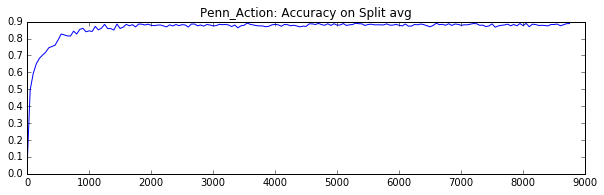

In [9]:
plt.figure(num=1, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(211)
plt.title('Penn_Action: Accuracy on Split avg')
plt.plot(plot_data[0][0],plot_data[1][0],'b-')
plt.show()

------
Sub-Jhmdb
------

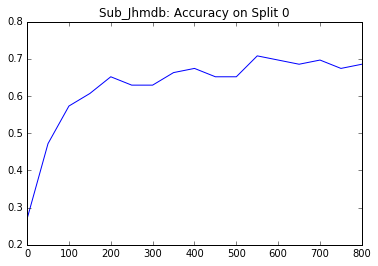

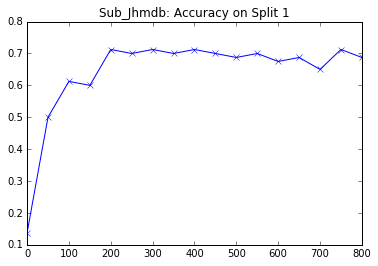

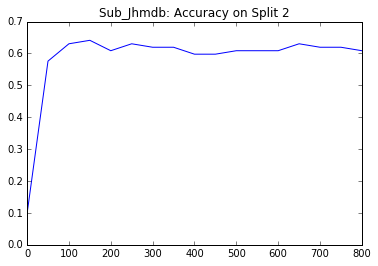

In [10]:
plt.figure()
plt.title('Sub_Jhmdb: Accuracy on Split 0')
plt.plot(plot_data[0][1],plot_data[1][1],'b-')
plt.figure()
plt.title('Sub_Jhmdb: Accuracy on Split 1')
plt.plot(plot_data[0][2],plot_data[1][2],'x-')
plt.figure()
plt.title('Sub_Jhmdb: Accuracy on Split 2')
plt.plot(plot_data[0][3],plot_data[1][3],'b-')
plt.show()

------
Jhmdb
------

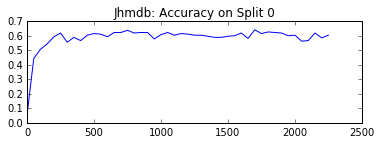

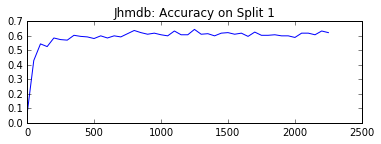

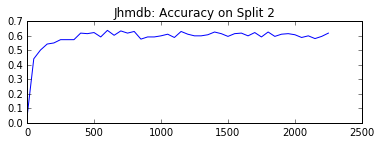

In [11]:
plt.figure(1)
plt.subplot(211)
plt.title('Jhmdb: Accuracy on Split 0')
plt.plot(plot_data[0][4],plot_data[1][4],'b-')
plt.figure(2)
plt.subplot(211)
plt.title('Jhmdb: Accuracy on Split 1')
plt.plot(plot_data[0][5],plot_data[1][5],'b-')
plt.figure(3)
plt.subplot(211)
plt.title('Jhmdb: Accuracy on Split 2')
plt.plot(plot_data[0][6],plot_data[1][6],'b-')
plt.show()

------
Florence 3d
------

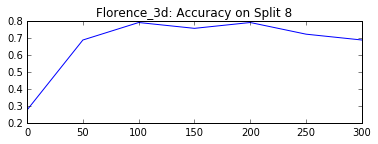

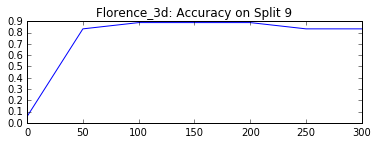

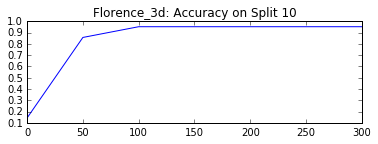

In [12]:
for k in range(7,10):
    plt.figure(k+1)
    plt.subplot(211)    
    plt.title('Florence_3d: Accuracy on Split '+ str(k+1))
    plt.plot(plot_data[0][k],plot_data[1][k],'b-')    
plt.show()

------
Bonn mocap
------

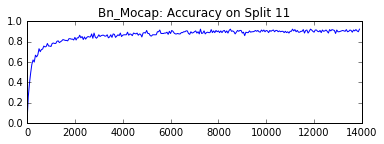

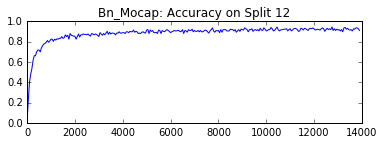

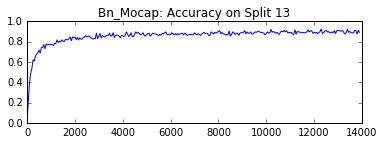

In [13]:
for k in range(10,13):
    plt.figure(k+1)
    plt.subplot(211)    
    plt.title('Bn_Mocap: Accuracy on Split '+ str(k+1))
    plt.plot(plot_data[0][k],plot_data[1][k],'b-')
plt.show()

In [14]:
exp4_end = datetime.datetime.utcnow()

In [15]:
experiments = []
print('The total time used in experiment 1 (default data) was', (exp1_end - exp1_start).total_seconds()/60, 'minutes')

print('experiment 1 in Penn_action:',(datasets_time1[1][0]-datasets_time1[0][0]).total_seconds()/60, 'minutes')
print('experiment 1 in Sub_jhmdb:',(datasets_time1[1][1]-datasets_time1[0][1]).total_seconds()/60, 'minutes')
print('experiment 1 in Jhmdb:',(datasets_time1[1][2]-datasets_time1[0][2]).total_seconds()/60, 'minutes')
print('experiment 1 in Florence3d:',(datasets_time1[1][3]-datasets_time1[0][3]).total_seconds()/60, 'minutes')
print('experiment 1 in Bn_mocap:',(datasets_time1[1][4]-datasets_time1[0][4]).total_seconds()/60, 'minutes')

'''

CORRECT THE NEXT EXPERIMENTS (change number): 

print('The total time used in experiment 2 (-1 FCN: 2FCN) was', (exp2_end - exp2_start).total_seconds()/60, 'minutes')

print('experiment 2 in Penn_action:',(exp2Penn_end-exp2Penn_start).total_seconds()/60, 'minutes')
print('experiment 2 in Sub_jhmdb:',(exp2SubJ_end-exp2SubJ_start).total_seconds()/60, 'minutes')
print('experiment 2 in Jhmdb:',(exp2Jhmdb_end-exp2Jhmdb_start).total_seconds()/60, 'minutes')
print('experiment 2 in Florence3d:',(exp2Flor_end-exp2Flor_start).total_seconds()/60, 'minutes')
print('experiment 2 in Bn_mocap:',(exp2BnM_end-exp2BnM_start).total_seconds()/60, 'minutes')

print('The total time used in experiment 3 (+1 FCN: 4FCN) was', (exp3_end - exp3_start).total_seconds()/60, 'minutes')

print('experiment 3 in Penn_action:',(exp3Penn_end-exp3Penn_start).total_seconds()/60, 'minutes')
print('experiment 3 in Sub_jhmdb:',(exp3SubJ_end-exp3SubJ_start).total_seconds()/60, 'minutes')
print('experiment 3 in Jhmdb:',(exp3Jhmdb_end-exp3Jhmdb_start).total_seconds()/60, 'minutes')
print('experiment 3 in Florence3d:',(exp3Flor_end-exp3Flor_start).total_seconds()/60, 'minutes')
print('experiment 3 in Bn_mocap:',(exp3BnM_end-exp3BnM_start).total_seconds()/60, 'minutes')

print('The total time used in experiment 4 (+2 FCN: 5FCN) was', (exp4_end - exp4_start).total_seconds()/60, 'minutes')

print('experiment 4 in Penn_action:',(exp4Penn_end-exp4Penn_start).total_seconds()/6sorry0, 'minutes')
print('experiment 4 in Sub_jhmdb:',(exp4SubJ_end-exp4SubJ_start).total_seconds()/60, 'minutes')
print('experiment 4 in Jhmdb:',(exp4Jhmdb_end-exp4Jhmdb_start).total_seconds()/60, 'minutes')
print('experiment 4 in Florence3d:',(exp4Flor_end-exp4Flor_start).total_seconds()/60, 'minutes')
print('experiment 4 in Bn_mocap:',(exp4BnM_end-exp4BnM_start).total_seconds()/60, 'minutes')

global_end = datetime.datetime.utcnow()
print('The total time used for all of the experiments was', (global_end - global_start).total_seconds()/3600, 'hours')'''

The total time used in experiment 1 (default data) was 6.2501154 minutes
experiment 1 in Penn_action: 1.0083141166666667 minutes
experiment 1 in Sub_jhmdb: 0.22812346666666666 minutes
experiment 1 in Jhmdb: 0.6207598666666667 minutes
experiment 1 in Florence3d: 0.11236838333333334 minutes
experiment 1 in Bn_mocap: 4.1221645 minutes


"\n\nCORRECT THE NEXT EXPERIMENTS (change number): \n\nprint('The total time used in experiment 2 (-1 FCN: 2FCN) was', (exp2_end - exp2_start).total_seconds()/60, 'minutes')\n\nprint('experiment 2 in Penn_action:',(exp2Penn_end-exp2Penn_start).total_seconds()/60, 'minutes')\nprint('experiment 2 in Sub_jhmdb:',(exp2SubJ_end-exp2SubJ_start).total_seconds()/60, 'minutes')\nprint('experiment 2 in Jhmdb:',(exp2Jhmdb_end-exp2Jhmdb_start).total_seconds()/60, 'minutes')\nprint('experiment 2 in Florence3d:',(exp2Flor_end-exp2Flor_start).total_seconds()/60, 'minutes')\nprint('experiment 2 in Bn_mocap:',(exp2BnM_end-exp2BnM_start).total_seconds()/60, 'minutes')\n\nprint('The total time used in experiment 3 (+1 FCN: 4FCN) was', (exp3_end - exp3_start).total_seconds()/60, 'minutes')\n\nprint('experiment 3 in Penn_action:',(exp3Penn_end-exp3Penn_start).total_seconds()/60, 'minutes')\nprint('experiment 3 in Sub_jhmdb:',(exp3SubJ_end-exp3SubJ_start).total_seconds()/60, 'minutes')\nprint('experiment 3 

In [1]:
for i in range(3,6):
    example+str(i) = i